In [1]:
import os

# 1) ENV VARS – before any TF import
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-12.3"
os.environ["CUDA_HOME"] = "/usr/local/cuda-12.3"

# 2) Sanity check
print("XLA_FLAGS:",    os.environ["XLA_FLAGS"])
print("Looking here:", os.path.exists(
    "/usr/local/cuda-12.3/nvvm/libdevice/libdevice.10.bc"
))


XLA_FLAGS: --xla_gpu_cuda_data_dir=/usr/local/cuda-12.3
Looking here: True


In [2]:
import sys
import tensorflow as tf

sys.path.insert(0, "/tmp/wandb_pkg")
import wandb
print("wandb version:", wandb.__version__)

# avoid matplotlib cache errors
os.environ["MPLCONFIGDIR"] = "/tmp/matplotlib"
# suppress TF INFO logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

2025-05-05 15:50:04.305427: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 15:50:04.324399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746485404.347106  106457 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746485404.353630  106457 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746485404.370876  106457 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

wandb version: 0.19.10


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime
import psutil
import subprocess
import GPUtil

# Enable script imports
sys.path.append(os.path.abspath(".."))

from scripts.data_loader import save_tokenize_data, MAX_VOCAB_SIZE, MAX_SEQ_LEN
from scripts.result_logger import log_results 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
#from tensorflow.keras.callbacks import TensorBoard


from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix
)

#import wandb
#from wandb.integration.keras import WandbCallback 
import wandb.integration.keras as wbk
print(dir(wbk))
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback
print("wandb version:", wandb.__version__)
print("wandb package path:", wandb.__file__)


['WandbCallback', 'WandbEvalCallback', 'WandbMetricsLogger', 'WandbModelCheckpoint', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'callbacks', 'keras']
wandb version: 0.19.10
wandb package path: /tmp/wandb_pkg/wandb/__init__.py


# CNN

In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load pre-processed data splits 
X_train_seq = np.load("../data/splits/X_train_seq.npy")
X_val_seq = np.load("../data/splits/X_val_seq.npy")
X_test_seq = np.load("../data/splits/X_test_seq.npy")
y_train_bin = np.load("../data/splits/y_train_bin.npy")
y_val_bin = np.load("../data/splits/y_val_bin.npy")
y_test_bin = np.load("../data/splits/y_test_bin.npy")

# GPU setup
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    raise RuntimeError("No GPU found.")
tf.config.experimental.set_memory_growth(gpus[0], True)
print("GPU ready:", gpus[0])


#  Best hyperparameters from sweep (op2fzrj4)
BEST_CONFIG = {
    "model": "CNN",
    "dataset": "Sentiment140",
    'batch_size': 128,
    'dense_units': 64,
    'dropout': 0.5,
    'embedding_dim': 128,
    'epochs': 5,
    'kernel_size': 5,
    'learning_rate': 0.0005,
    'num_filters': 128,
    'optimizer': "rmsprop",
    'metric_goal':"maximize",
    'metric_name':"val_accuracy",
    'model_type':"CNN",
}

GPU ready: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
# wandb Init
wandb.init(
    project="sentiment-analysis", 
    name="CNN_Social", 
    config=BEST_CONFIG
)

wbcfg = wandb.config

2025/05/05 15:50:37 ERROR failed to get logger path error="error creating log directory: mkdir /home/smpandit/.cache/wandb: disk quota exceeded"
2025/05/05 15:50:37 INFO Will exit if parent process dies. ppid=106457
2025/05/05 15:50:37 INFO server is running addr=127.0.0.1:35559
2025/05/05 15:50:37 INFO connection: ManageConnectionData: new connection created id=127.0.0.1:33732
wandb: Currently logged in as: smpandit (smpandit-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
2025/05/05 15:50:38 INFO handleInformInit: received streamId=zwrgk3sr id=127.0.0.1:33732
2025/05/05 15:50:38 INFO handleInformInit: stream started streamId=zwrgk3sr id=127.0.0.1:33732


In [6]:
# Build CNN model

start_time = time.time()

cnn_model = Sequential([
    Embedding(
        input_dim=MAX_VOCAB_SIZE, 
        output_dim=wbcfg.embedding_dim, 
        input_length=MAX_SEQ_LEN
    ),
    Conv1D(
        filters=wbcfg.num_filters,
        kernel_size=wbcfg.kernel_size,
        activation='relu'
    ),              
    GlobalMaxPooling1D(),
    Dense(wbcfg.dense_units, activation='relu'),                   
    Dropout(wbcfg.dropout),
    Dense(1, activation='sigmoid')                   
])

# Compile CNN model
opt = Adam(learning_rate=wbcfg.learning_rate) if wbcfg.optimizer == "adam" else RMSprop(learning_rate=wbcfg.learning_rate)


cnn_model.compile(
    optimizer=opt, 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)            

build_compile_time_cnn = time.time() - start_time

/home/smpandit/.conda/envs/sentimentAnalysisENV/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1746485442.096388  106457 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29365 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:03:00.0, compute capability: 8.0


In [7]:
# Train CNN model

start_time = time.time()

history = cnn_model.fit(
    X_train_seq, 
    y_train_bin,
    validation_data=(
        X_val_seq, 
        y_val_bin
    ),
    epochs=wbcfg.epochs,
    batch_size=wbcfg.batch_size,
    callbacks=wbk.WandbMetricsLogger(),
    verbose=1
)

train_time = time.time() - start_time

Epoch 1/5


I0000 00:00:1746485449.902341  126101 service.cc:152] XLA service 0x7febc401ade0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746485449.902387  126101 service.cc:160]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-05-05 15:50:49.947114: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746485450.306764  126101 cuda_dnn.cc:529] Loaded cuDNN version 90800
I0000 00:00:1746485457.980290  126101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8728/8728 ━━━━━━━━━━━━━━━━━━━━ 3533s 404ms/step - accuracy: 0.7669 - loss: 0.4800 - val_accuracy: 0.8151 - val_loss: 0.4060
Epoch 2/5
8728/8728 ━━━━━━━━━━━━━━━━━━━━ 3515s 403ms/step - accuracy: 0.8190 - loss: 0.4051 - val_accuracy: 0.8205 - val_loss: 0.3971
Epoch 3/5
8728/8728 ━━━━━━━━━━━━━━━━━━━━ 3425s 392ms/step - accuracy: 0.8285 - loss: 0.3877 - val_accuracy: 0.8230 - val_loss: 0.3950
Epoch 4/5
8728/8728 ━━━━━━━━━━━━━━━━━━━━ 3352s 384ms/step - accuracy: 0.8358 - loss: 0.3744 - val_accuracy: 0.8215 - val_loss: 0.4018
Epoch 5/5
8728/8728 ━━━━━━━━━━━━━━━━━━━━ 3398s 389ms/step - accuracy: 0.8420 - loss: 0.3627 - val_accuracy: 0.8198 - val_loss: 0.4080


In [8]:
# Validation Evaluation
y_val_preds_cnn = (cnn_model.predict(X_val_seq) > 0.5).astype("int32")

print("\n CNN Model - Validation Set:")
print(classification_report(y_val_bin, y_val_preds_cnn))

val_acc = accuracy_score(y_val_bin, y_val_preds_cnn)
val_prec = precision_score(y_val_bin, y_val_preds_cnn)
val_rec = recall_score(y_val_bin, y_val_preds_cnn)
val_f1 = f1_score(y_val_bin, y_val_preds_cnn)

7483/7483 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step

 CNN Model - Validation Set:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81    119762
           1       0.80      0.86      0.83    119680

    accuracy                           0.82    239442
   macro avg       0.82      0.82      0.82    239442
weighted avg       0.82      0.82      0.82    239442



In [9]:
# Test Evaluation
y_test_preds_cnn = (cnn_model.predict(X_test_seq) > 0.5).astype("int32").flatten()

print("\n CNN Model - Test Set:")
print(classification_report(y_test_bin, y_test_preds_cnn))

acc = accuracy_score(y_test_bin, y_test_preds_cnn)
prec = precision_score(y_test_bin, y_test_preds_cnn)
rec = recall_score(y_test_bin, y_test_preds_cnn)
f1 = f1_score(y_test_bin, y_test_preds_cnn)


7482/7482 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step

 CNN Model - Test Set:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81    119742
           1       0.80      0.86      0.83    119660

    accuracy                           0.82    239402
   macro avg       0.82      0.82      0.82    239402
weighted avg       0.82      0.82      0.82    239402



In [10]:
# Inference time 
start_infer = time.time()
test_preds = (cnn_model.predict(X_test_seq) > 0.5).astype("int32")
infer_time = (time.time() - start_infer) / len(X_test_seq)  # avg per sample

7482/7482 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step


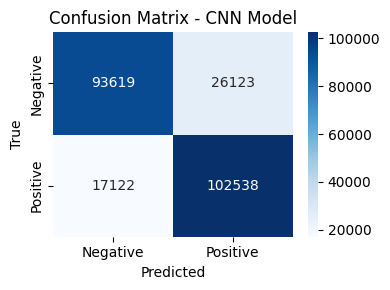

In [11]:
# Confusion Matrix

cm = confusion_matrix(y_test_bin, y_test_preds_cnn, labels=[0, 1])
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix - CNN Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("cnn_confusion_matrix.png")

In [12]:
# Systems Stats

cpu_usage = psutil.cpu_percent(interval=1)
mem_usage = psutil.virtual_memory().percent
gpu = GPUtil.getGPUs()[0]
power = subprocess.check_output([
    "nvidia-smi", "--query-gpu=power.draw", "--format=csv,noheader,nounits"
]).decode("utf-8").strip()

In [16]:
print("CWD:", os.getcwd())
print("Files in ../data:", os.listdir("../data"))
df = pd.read_csv("../data/sweep_cnn.csv")
print("Columns in sweep_cnn.csv:", df.columns.tolist())

CWD: /research2/smpandit/Sentiment_Analysis_ML_DL_LLM/notebooks
Files in ../data: ['sweep_cnn.csv', 'splits', 'social_clean.csv', 'sweep_bilstm.csv']
Columns in sweep_cnn.csv: ['Name           ', ' "Tags"     ', ' "State"   ', ' "Created"                 ', ' "Runtime"', ' "ID"      ', ' "Updated"                 ', ' "End Time"                ', ' "Notes"                                 ', ' "dataset"', ' "Hostname"', ' "GPU Type"             ', ' "Commit"                                  ', ' "GitHub"', ' "GPU Count"', ' "Validation Accuracy"', ' "Validation Precision"', ' "Validation F1 Score"', ' "Validation Recall"', ' "Test Accuracy"', ' "Test Precision"', ' "Test F1 Score"', ' "Test Recall"', ' "Tuning Time (s)"', ' "Training Time (s)"', ' "Inference Time per Sample (s)"', ' "Latency (ms)"', ' "vectorizer"', ' "C"', ' "batch_size"', ' "dense_units"', ' "dropout"', ' "embedding_dim"', ' "epochs"', ' "features"', ' "kernel_size"', ' "learning_rate"', ' "lstm_units"', ' "num_filter

In [23]:
# Read sweep CSV                          
sweep_cnn_df = pd.read_csv("../data/sweep_cnn.csv")

# Clean the column names (strip whitespace & remove quotes)
sweep_cnn_df.columns = (
    sweep_cnn_df.columns
      .str.strip()           # drop leading/trailing spaces
      .str.replace('"','')   # remove literal double-quotes
      .str.strip()           # trim again
)

# Convert the time columns to numeric
sweep_cnn_df['training_time'] = pd.to_numeric(sweep_cnn_df['training_time'], errors='coerce')
sweep_cnn_df['tuning_time']   = pd.to_numeric(sweep_cnn_df['tuning_time'],   errors='coerce')

# Sum up all sweep runs' tuning time & training time
total_training_time_cnn = sweep_cnn_df['training_time'].sum()
total_tuning_time_cnn = sweep_cnn_df['tuning_time'].sum()

print(total_training_time_cnn, total_tuning_time_cnn)

# Sum uo the total tuning & training time
total_sweep_time_cnn = total_training_time_cnn + total_tuning_time_cnn 

build_compile_time_cnn = float(build_compile_time_cnn)

# Add to the best param model's tuning time to get total tuning time
total_tuning_time = total_sweep_time_cnn + build_compile_time_cnn
print(total_tuning_time)

11650.665705680847 0.7241494655609128
11652.098714828491


In [24]:
# Log results to  result_logger.py & wandb Logs

log_results(
    model_name="CNN",
    dataset_name="Social Media",
    accuracy=acc,
    precision=prec,
    recall=rec,
    f1=f1,
    tuning_time=total_tuning_time,                           
    train_time=train_time,
    inference_time=infer_time,
    latency=infer_time * 1000,
    cpu_usage=cpu_usage,
    mem_usage=mem_usage,
    gpu_usage=gpu.load * 100,
    gpu_mem_usage=gpu.memoryUtil * 100,
    gpu_temp=gpu.temperature,
    power=float(power),
    num_features=MAX_VOCAB_SIZE,
    hyperparams=f"batch={wbcfg.batch_size}, epochs={wbcfg.epochs}, embedding_dim={wbcfg.embedding_dim}, dropout={wbcfg.dropout}, dense_units={wbcfg.dense_units}, learning_rate={wbcfg.learning_rate}, optimizer={wbcfg.optimizer}, num_filters={wbcfg.num_filters}, kernel_size={wbcfg.kernel_size}" 
)

wandb.log({
    "Validation Accuracy": val_acc, 
    "Validation Precision": val_prec,
    "Validation Recall": val_rec, 
    "Validation F1 Score": val_f1,

    "Test Accuracy": acc,
    "Test Precision": prec,
    "Test Recall": rec,
    "Test F1 Score": f1,

    "Tuning Time (s)": total_tuning_time,             
    "Training Time (s)": train_time,
    "Inference Time per Sample (s)": infer_time,
    "Latency (ms)": infer_time * 1000,

    "CPU Usage (%)": cpu_usage,
    "Memory Usage (%)": mem_usage,
    "GPU Usage (%)": gpu.load * 100,
    "GPU Memory Usage (%)": gpu.memoryUtil * 100,
    "GPU Temp (C)": gpu.temperature,
    "Power Consumption (W)": float(power), 

    "features": 10000, 
    "max_len": 100,

    "Confusion Matrix": wandb.Image("cnn_confusion_matrix.png")
})

wandb.finish()

Logged: CNN on Social Media to ../results/results.csv


CPU Usage (%),▁
GPU Memory Usage (%),▁
GPU Temp (C),▁
GPU Usage (%),▁
Inference Time per Sample (s),▁
Latency (ms),▁
Memory Usage (%),▁
Power Consumption (W),▁
Test Accuracy,▁
Test F1 Score,▁
Test Precision,▁


2025/05/05 21:04:14 INFO handleInformFinish: finish message received streamId=zwrgk3sr id=127.0.0.1:33732
2025/05/05 21:04:14 INFO handleInformFinish: stream closed streamId=zwrgk3sr id=127.0.0.1:33732


# BiLSTM

In [25]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load pre-processed data splits 
X_train_seq = np.load("../data/splits/X_train_seq.npy")
X_val_seq = np.load("../data/splits/X_val_seq.npy")
X_test_seq = np.load("../data/splits/X_test_seq.npy")
y_train_bin = np.load("../data/splits/y_train_bin.npy")
y_val_bin = np.load("../data/splits/y_val_bin.npy")
y_test_bin = np.load("../data/splits/y_test_bin.npy")

# GPU setup
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    raise RuntimeError("No GPU found.")
tf.config.experimental.set_memory_growth(gpus[0], True)
print("GPU ready:", gpus[0])


#  Best hyperparameters from sweep (03joa3ol)
BEST_CONFIG = {                                  
    "model": "BiLSTM",
    "dataset": "Sentiment140",
    'batch_size': 128,
    'dense_units': 32,
    'dropout': 0.2,
    'embedding_dim': 128,
    'epochs': 5,
    'learning_rate': 0.001,
    'lstm_units': 64,
    'optimizer': "adam",
    'metric_goal':"maximize",
    'metric_name':"val_accuracy",
    'model_type':"BiLSTM",
}

GPU ready: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [26]:
# wandb Init
wandb.init(
    project="sentiment-analysis", 
    name="BiLSTM_Social", 
    config=BEST_CONFIG
)

wbcfg = wandb.config

2025/05/05 21:08:04 INFO handleInformInit: received streamId=hbq98fbx id=127.0.0.1:33732
2025/05/05 21:08:04 INFO handleInformInit: stream started streamId=hbq98fbx id=127.0.0.1:33732


In [27]:
# Build BiLSTM model

start_time = time.time()

bilstm_model = Sequential([
    Embedding(
        input_dim=MAX_VOCAB_SIZE, 
        output_dim=wbcfg.embedding_dim, 
        input_length=MAX_SEQ_LEN
    ),
    Bidirectional(
        LSTM(
            units=wbcfg.lstm_units,
            dropout=wbcfg.dropout,
            recurrent_dropout=0.2,
            return_sequences=False
        )
    ),
    Dense(wbcfg.dense_units, activation='relu'),                   
    Dropout(wbcfg.dropout),
    Dense(1, activation='sigmoid')   
])

# Compile BiLSTM model 
opt = Adam(learning_rate=wbcfg.learning_rate) if wbcfg.optimizer == "adam" else RMSprop(learning_rate=wbcfg.learning_rate)

bilstm_model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

build_compile_time_bilstm = time.time() - start_time

/home/smpandit/.conda/envs/sentimentAnalysisENV/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
# Train BiLSTM model

start_time = time.time()

history = bilstm_model.fit(
    X_train_seq, 
    y_train_bin,
    validation_data=(
        X_val_seq, 
        y_val_bin
    ),
    epochs=wbcfg.epochs,
    batch_size=wbcfg.batch_size,
    callbacks=wbk.WandbMetricsLogger(),
    verbose=1
)

train_time = time.time() - start_time

Epoch 1/5
8728/8728 ━━━━━━━━━━━━━━━━━━━━ 6474s 740ms/step - accuracy: 0.7819 - loss: 0.4584 - val_accuracy: 0.8173 - val_loss: 0.4007
Epoch 2/5
8728/8728 ━━━━━━━━━━━━━━━━━━━━ 3768s 432ms/step - accuracy: 0.8194 - loss: 0.3989 - val_accuracy: 0.8222 - val_loss: 0.3917
Epoch 3/5
8728/8728 ━━━━━━━━━━━━━━━━━━━━ 3483s 395ms/step - accuracy: 0.8284 - loss: 0.3811 - val_accuracy: 0.8247 - val_loss: 0.3893
Epoch 4/5
8728/8728 ━━━━━━━━━━━━━━━━━━━━ 6109s 700ms/step - accuracy: 0.8364 - loss: 0.3669 - val_accuracy: 0.8251 - val_loss: 0.3929
Epoch 5/5
8728/8728 ━━━━━━━━━━━━━━━━━━━━ 4149s 475ms/step - accuracy: 0.8430 - loss: 0.3550 - val_accuracy: 0.8243 - val_loss: 0.3992


In [29]:
# Validation Evaluation
y_val_preds_bilstm = (bilstm_model.predict(X_val_seq) > 0.5).astype("int32")

print("\n BiLSTM Model - Validation Set:")
print(classification_report(y_val_bin, y_val_preds_bilstm))

val_acc = accuracy_score(y_val_bin, y_val_preds_bilstm)
val_prec = precision_score(y_val_bin, y_val_preds_bilstm)
val_rec = recall_score(y_val_bin, y_val_preds_bilstm)
val_f1 = f1_score(y_val_bin, y_val_preds_bilstm)

7483/7483 ━━━━━━━━━━━━━━━━━━━━ 646s 86ms/step

 BiLSTM Model - Validation Set:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83    119762
           1       0.83      0.82      0.82    119680

    accuracy                           0.82    239442
   macro avg       0.82      0.82      0.82    239442
weighted avg       0.82      0.82      0.82    239442



In [30]:
# Test Evaluation
y_test_preds_bilstm = (bilstm_model.predict(X_test_seq) > 0.5).astype("int32").flatten()

print("\n CNN Model - Test Set:")
print(classification_report(y_test_bin, y_test_preds_bilstm))

acc = accuracy_score(y_test_bin, y_test_preds_bilstm)
prec = precision_score(y_test_bin, y_test_preds_bilstm)
rec = recall_score(y_test_bin, y_test_preds_bilstm)
f1 = f1_score(y_test_bin, y_test_preds_bilstm)


7482/7482 ━━━━━━━━━━━━━━━━━━━━ 645s 86ms/step

 CNN Model - Test Set:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83    119742
           1       0.83      0.82      0.82    119660

    accuracy                           0.82    239402
   macro avg       0.82      0.82      0.82    239402
weighted avg       0.82      0.82      0.82    239402



In [31]:
# Inference time 
start_infer = time.time()
test_preds = (bilstm_model.predict(X_test_seq) > 0.5).astype("int32")
infer_time = (time.time() - start_infer) / len(X_test_seq)  # avg per sample

7482/7482 ━━━━━━━━━━━━━━━━━━━━ 643s 86ms/step


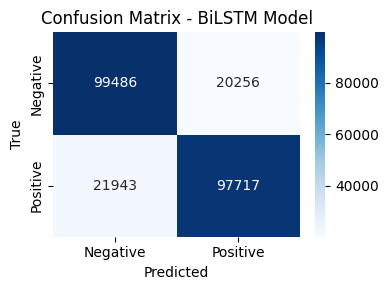

In [32]:
# Confusion Matrix

cm = confusion_matrix(y_test_bin, y_test_preds_bilstm, labels=[0, 1])
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix - BiLSTM Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("bilstm_confusion_matrix.png")

In [33]:
# Systems Stats

cpu_usage = psutil.cpu_percent(interval=1)
mem_usage = psutil.virtual_memory().percent
gpu = GPUtil.getGPUs()[0]
power = subprocess.check_output([
    "nvidia-smi", "--query-gpu=power.draw", "--format=csv,noheader,nounits"
]).decode("utf-8").strip()

In [35]:
# Read sweep CSV                          
sweep_bilstm_df = pd.read_csv("../data/sweep_bilstm.csv")

# Clean the column names (strip whitespace & remove quotes)
sweep_bilstm_df.columns = (
    sweep_bilstm_df.columns
      .str.strip()           # drop leading/trailing spaces
      .str.replace('"','')   # remove literal double-quotes
      .str.strip()           # trim again
)

# Convert the time columns to numeric
sweep_bilstm_df['training_time'] = pd.to_numeric(sweep_bilstm_df['training_time'], errors='coerce')
sweep_bilstm_df['tuning_time']   = pd.to_numeric(sweep_bilstm_df['tuning_time'],   errors='coerce')

# Sum up all sweep runs' tuning time & training time
total_training_time_bilstm = sweep_bilstm_df['training_time'].sum()
total_tuning_time_bilstm = sweep_bilstm_df['tuning_time'].sum()

print(total_training_time_bilstm, total_tuning_time_bilstm)

# Sum uo the total tuning & training time
total_sweep_time_bilstm = total_training_time_bilstm + total_tuning_time_bilstm 

build_compile_time_bilstm = float(build_compile_time_bilstm)

# Add to the best param model's tuning time to get total tuning time
total_tuning_time = total_sweep_time_bilstm + build_compile_time_bilstm
print(total_tuning_time)

48895.53416323662 0.5702390670776363
48896.15851140022


In [36]:
# Log results to  result_logger.py & wandb Logs

log_results(
    model_name="BiLSTM",
    dataset_name="Social Media",
    accuracy=acc,
    precision=prec,
    recall=rec,
    f1=f1,
    tuning_time=total_tuning_time,                           
    train_time=train_time,
    inference_time=infer_time,
    latency=infer_time * 1000,
    cpu_usage=cpu_usage,
    mem_usage=mem_usage,
    gpu_usage=gpu.load * 100,
    gpu_mem_usage=gpu.memoryUtil * 100,
    gpu_temp=gpu.temperature,
    power=float(power),
    num_features=MAX_VOCAB_SIZE,
    hyperparams=f"batch={wbcfg.batch_size}, epochs={wbcfg.epochs}, embedding_dim={wbcfg.embedding_dim}, dropout={wbcfg.dropout}, dense_units={wbcfg.dense_units}, learning_rate={wbcfg.learning_rate}, optimizer={wbcfg.optimizer}, lstm_units={wbcfg.lstm_units}" 
)

wandb.log({
    "Validation Accuracy": val_acc, 
    "Validation Precision": val_prec,
    "Validation Recall": val_rec, 
    "Validation F1 Score": val_f1,

    "Test Accuracy": acc,
    "Test Precision": prec,
    "Test Recall": rec,
    "Test F1 Score": f1,

    "Tuning Time (s)": total_tuning_time,             
    "Training Time (s)": train_time,
    "Inference Time per Sample (s)": infer_time,
    "Latency (ms)": infer_time * 1000,

    "CPU Usage (%)": cpu_usage,
    "Memory Usage (%)": mem_usage,
    "GPU Usage (%)": gpu.load * 100,
    "GPU Memory Usage (%)": gpu.memoryUtil * 100,
    "GPU Temp (C)": gpu.temperature,
    "Power Consumption (W)": float(power), 

    "features": 10000, 
    "max_len": 100,

    "Confusion Matrix": wandb.Image("bilstm_confusion_matrix.png")
})

wandb.finish()

Logged: BiLSTM on Social Media to ../results/results.csv


CPU Usage (%),▁
GPU Memory Usage (%),▁
GPU Temp (C),▁
GPU Usage (%),▁
Inference Time per Sample (s),▁
Latency (ms),▁
Memory Usage (%),▁
Power Consumption (W),▁
Test Accuracy,▁
Test F1 Score,▁
Test Precision,▁


2025/05/06 04:27:16 INFO handleInformFinish: finish message received streamId=hbq98fbx id=127.0.0.1:33732
2025/05/06 04:27:16 INFO handleInformFinish: stream closed streamId=hbq98fbx id=127.0.0.1:33732
